In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Add the project root (toy-wm directory) to sys.path so we can import src as a package
# This allows relative imports within the package to work correctly
# Assumes notebook is run from the project root directory
project_root = os.getcwd()  # or use: os.path.dirname(os.path.abspath(''))
print(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

/share/u/wendler/code/toy-wm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t

# Import using absolute path from src package
from src.utils.checkpoint import load_model_from_config

#model = load_model_from_config("configs/small_6frame.yaml")
model = load_model_from_config("configs/inference.yaml", strict=False)
model.eval()

loading configs/inference.yaml


CausalDit(
  (rope_seq): RoPE()
  (blocks): ModuleList(
    (0-7): 8 x CausalBlock(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (selfattn): AttentionEinOps(
        (rope): RoPE()
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (geglu): GEGLU(
        (up_proj): Linear(in_features=384, out_features=1536, bias=True)
        (up_gate): Linear(in_features=384, out_features=1536, bias=True)
        (down): Linear(in_features=1536, out_features=384, bias=True)
        (nonlin): SiLU()
      )
      (modulation): Sequential(
        (0): SiLU()
        (1): Linear(in_features=384, out_features=2304, bias=True)
      )
    )
  )
  (patch): Patch(
    (init_conv_seq): Sequential(
      (0): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): SiLU()
      (2): GroupNorm(3

In [3]:
model.activate_caching(1, 300)

torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 0
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 1
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 2
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 3
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 4
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 5
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 6
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 

In [4]:
from src.datasets.pong1m import get_loader

loader, pred2frame = get_loader(duration=1, fps=30, mode='-1,1')
frames, actions = next(iter(loader))
frames = pred2frame(frames)

520 batches


In [5]:
from src.trainers.diffusion_forcing import sample

def render_video(actions, n_steps=8, cfg=0, negative_actions=None, clamp=True):
    model.cache.reset()
    device = model.device
    frames = t.randn(1, actions.shape[1], 3, 24, 24, device="cpu")
    for aidx in range(actions.shape[1]):
        print(aidx)
        noise = t.randn(1, 1, 3, 24, 24, device=device)
        z = sample(model, noise, actions[:, aidx:aidx+1], num_steps=n_steps, cfg=cfg, negative_actions=negative_actions)
        model.cache.update_global_location(1)
        frames[:, aidx:aidx+1] = z.detach().cpu()
        if clamp:
            frames = frames.clamp(-1, 1)
    return frames

In [6]:
#model = t.compile(model)

0


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 42.19it/s]


1


100%|██████████| 8/8 [00:00<00:00, 45.95it/s]


2


100%|██████████| 8/8 [00:00<00:00, 44.15it/s]


3


100%|██████████| 8/8 [00:00<00:00, 41.45it/s]


4


100%|██████████| 8/8 [00:00<00:00, 42.50it/s]


5


100%|██████████| 8/8 [00:00<00:00, 36.54it/s]


6


100%|██████████| 8/8 [00:00<00:00, 39.90it/s]


7


100%|██████████| 8/8 [00:00<00:00, 37.03it/s]


8


100%|██████████| 8/8 [00:00<00:00, 37.35it/s]


9


100%|██████████| 8/8 [00:00<00:00, 37.09it/s]


10


100%|██████████| 8/8 [00:00<00:00, 35.04it/s]


11


100%|██████████| 8/8 [00:00<00:00, 32.76it/s]


12


100%|██████████| 8/8 [00:00<00:00, 33.37it/s]


13


100%|██████████| 8/8 [00:00<00:00, 33.98it/s]


14


100%|██████████| 8/8 [00:00<00:00, 35.19it/s]


15


100%|██████████| 8/8 [00:00<00:00, 34.28it/s]


16


100%|██████████| 8/8 [00:00<00:00, 33.27it/s]


17


100%|██████████| 8/8 [00:00<00:00, 31.29it/s]


18


100%|██████████| 8/8 [00:00<00:00, 31.65it/s]


19


100%|██████████| 8/8 [00:00<00:00, 30.74it/s]


20


100%|██████████| 8/8 [00:00<00:00, 28.44it/s]


21


100%|██████████| 8/8 [00:00<00:00, 29.83it/s]


22


100%|██████████| 8/8 [00:00<00:00, 29.26it/s]


23


100%|██████████| 8/8 [00:00<00:00, 26.38it/s]


24


100%|██████████| 8/8 [00:00<00:00, 27.35it/s]


25


100%|██████████| 8/8 [00:00<00:00, 27.74it/s]


26


100%|██████████| 8/8 [00:00<00:00, 26.56it/s]


27


100%|██████████| 8/8 [00:00<00:00, 26.92it/s]


28


100%|██████████| 8/8 [00:00<00:00, 25.89it/s]


29


100%|██████████| 8/8 [00:00<00:00, 23.46it/s]


30


100%|██████████| 8/8 [00:00<00:00, 23.06it/s]


31


100%|██████████| 8/8 [00:00<00:00, 19.98it/s]


32


100%|██████████| 8/8 [00:00<00:00, 21.11it/s]


33


100%|██████████| 8/8 [00:00<00:00, 20.35it/s]


34


100%|██████████| 8/8 [00:00<00:00, 21.08it/s]


35


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


36


100%|██████████| 8/8 [00:00<00:00, 19.94it/s]


37


100%|██████████| 8/8 [00:00<00:00, 22.83it/s]


38


100%|██████████| 8/8 [00:00<00:00, 22.15it/s]


39


100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


40


100%|██████████| 8/8 [00:00<00:00, 20.84it/s]


41


100%|██████████| 8/8 [00:00<00:00, 22.04it/s]


42


100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


43


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


44


100%|██████████| 8/8 [00:00<00:00, 21.54it/s]


45


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


46


100%|██████████| 8/8 [00:00<00:00, 21.60it/s]


47


100%|██████████| 8/8 [00:00<00:00, 22.11it/s]


48


100%|██████████| 8/8 [00:00<00:00, 21.23it/s]


49


100%|██████████| 8/8 [00:00<00:00, 22.09it/s]


50


100%|██████████| 8/8 [00:00<00:00, 19.24it/s]


51


100%|██████████| 8/8 [00:00<00:00, 22.24it/s]


52


100%|██████████| 8/8 [00:00<00:00, 21.63it/s]


53


100%|██████████| 8/8 [00:00<00:00, 20.53it/s]


54


100%|██████████| 8/8 [00:00<00:00, 21.69it/s]


55


100%|██████████| 8/8 [00:00<00:00, 20.92it/s]


56


100%|██████████| 8/8 [00:00<00:00, 21.26it/s]


57


100%|██████████| 8/8 [00:00<00:00, 21.59it/s]


58


100%|██████████| 8/8 [00:00<00:00, 22.68it/s]


59


100%|██████████| 8/8 [00:00<00:00, 21.20it/s]


60


100%|██████████| 8/8 [00:00<00:00, 21.71it/s]


61


100%|██████████| 8/8 [00:00<00:00, 22.08it/s]


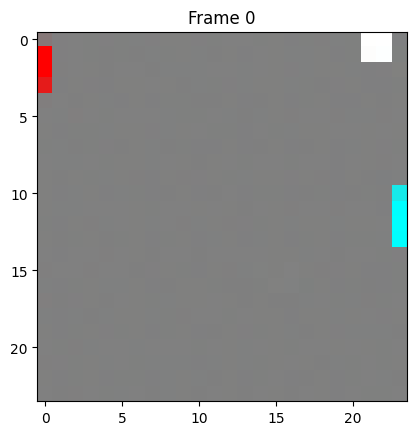

In [ ]:
actions = t.tensor([[0,0]+30*[2]+30*[3]], dtype=t.int32, device=model.device)
negative_actions = t.tensor([[0]+29*[2]], dtype=t.int32, device=model.device)
z = render_video(actions, n_steps=8, cfg=0, negative_actions=None, clamp=False)
frames = pred2frame(z)

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = frames[0].permute(0, 2, 3, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

# Optional: To save the gif uncomment below (requires pillow, install with `pip install pillow`)
from collections import Counter
# Majority vote over values in actions for the filename
if actions is not None:
    # Flatten actions tensor and convert to list
    action_vals = actions.flatten().tolist()
    majority_val = Counter(action_vals).most_common(1)[0][0]
    ani.save(f"sample_{majority_val}.gif", writer="pillow")
else:
    ani.save("sample_unknown.gif", writer="pillow")


